In [65]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# For image processing
from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
import torch


In [66]:
# Load the CSV file
data = pd.read_csv('../data/instagram_data.csv')

# Check for missing values and handle them
data.dropna(inplace=True)


In [67]:
# Calculate the 33rd and 66th percentiles
p33 = np.percentile(data['likes'], 33)
p66 = np.percentile(data['likes'], 66)

# Define the bins based on percentiles
bins = [0, p33, p66, np.inf]
labels = ['Low', 'Medium', 'High']

# Categorize the 'likes' column using these percentiles
data['likes_class'] = pd.cut(data['likes'], bins=bins, labels=labels)

# Print the chosen bin ranges
print(f"Low: 0 to {p33}")
print(f"Medium: {p33} to {p66}")
print(f"High: {p66} and above")


# Encode labels to numeric values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['likes_class_encoded'] = le.fit_transform(data['likes_class'])


Low: 0 to 68295.68000000001
Medium: 68295.68000000001 to 189775.28
High: 189775.28 and above


In [68]:
from PIL import Image
import numpy as np
import pandas as pd

# Function to extract color histogram features from an image
def extract_color_histogram(image_path):
    try:
        # Open the image and convert to RGB
        image = Image.open(image_path).convert('RGB')
        
        # Resize the image to 128x128
        image = image.resize((128, 128))
        
        # Convert the image to a NumPy array
        image = np.array(image)
        
        # Compute histograms for each color channel (R, G, B) with 256 bins each
        r_hist = np.histogram(image[:, :, 0], bins=256, range=(0, 256))[0]
        g_hist = np.histogram(image[:, :, 1], bins=256, range=(0, 256))[0]
        b_hist = np.histogram(image[:, :, 2], bins=256, range=(0, 256))[0]
        
        # Concatenate the histograms into a single feature vector (768 elements in total)
        hist_features = np.concatenate([r_hist, g_hist, b_hist])
        return hist_features
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Initialize a list to store the extracted features
image_features = []

# Iterate over each image path in the dataset (assuming 'data' DataFrame has an 'image_path' column)
for idx, row in data.iterrows():
    img_path = row['image_path']
    
    # Extract color histogram features
    features = extract_color_histogram(img_path)
    
    # If feature extraction succeeds, append the features; otherwise, append a zero vector of size 768
    if features is not None:
        image_features.append(features)
    else:
        image_features.append(np.zeros(768))  # Zero vector for color histogram features

# Convert the list of features into a DataFrame
image_features_df = pd.DataFrame(image_features)

# Optionally, check the shape of the resulting DataFrame
print(f"Extracted features for {len(image_features)} images with {image_features_df.shape[1]} features each.")


Extracted features for 3785 images with 768 features each.


In [69]:
# Let's assume image_features_df has 2048 columns (from ResNet50 features)

# Generate new column names with a prefix
feature_columns = [f'feat_{i}' for i in range(image_features_df.shape[1])]

# Assign new column names to image_features_df
image_features_df.columns = feature_columns


In [70]:
# Reset indices to ensure alignment
data.reset_index(drop=True, inplace=True)
image_features_df.reset_index(drop=True, inplace=True)

# Combine data and image features
combined_data = pd.concat([data, image_features_df], axis=1)


In [71]:
exclude_columns = ['likes', 't', 'image_path', 'likes_class', 'likes_class_encoded']
feature_columns = [col for col in combined_data.columns if col not in exclude_columns]


In [72]:
X = combined_data[feature_columns]
y = combined_data['likes_class_encoded']


In [73]:
# Convert all column names to strings (should already be strings after renaming)
X.columns = X.columns.map(str)


In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [75]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [76]:
y_pred = model.predict(X_test)


              precision    recall  f1-score   support

         Low       0.67      0.70      0.69       257
      Medium       0.64      0.70      0.67       250
        High       0.48      0.42      0.44       250

    accuracy                           0.61       757
   macro avg       0.60      0.60      0.60       757
weighted avg       0.60      0.61      0.60       757



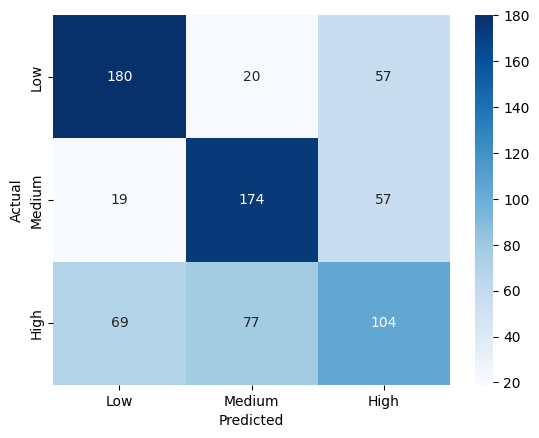

In [77]:
print(classification_report(y_test, y_pred, target_names=labels))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
